In [1]:
### Install Qiskit and relevant packages, if needed
### IMPORTANT: Make sure you are on 3.10 > python < 3.12
%pip install -q qiskit[visualization]==1.0.2
%pip install -q qiskit-ibm-runtime
%pip install -q qiskit-aer
%pip install -q graphviz
%pip install -q qiskit-serverless -U
%pip install -q qiskit-transpiler-service -U
%pip install -q git+https://github.com/qiskit-community/Quantum-Challenge-Grader.git -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 25.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.4/324.4 kB 23.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 54.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
# Set up api token
%set_env QXToken=insertToken

env: QXToken=insertToken


In [ ]:
# qc-grader should be 0.18.12 (or higher)
import qc_grader

qc_grader.__version__

'0.18.13'

In [ ]:
# Import all in one cell
import numpy as np
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import warnings

from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.circuit.random import random_circuit
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit.library import TwoLocal, EfficientSU2
from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Session, Options
from qiskit_serverless import QiskitFunction, save_result, get_arguments, save_result, distribute_task, distribute_qiskit_function, IBMServerlessClient, QiskitFunction
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_transpiler_service.transpiler_service import TranspilerService
from qiskit_aer import AerSimulator

# Import for grader
from qc_grader.challenges.iqc_2024 import grade_lab3_qs_ex1, grade_lab3_qs_ex2

In [ ]:
# If needed setup your QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="insert token",
    set_as_default=True,
    # Use `overwrite=True` if you're updating your token.
    overwrite=False,
)

service = QiskitRuntimeService(channel="ibm_quantum")

# Specify a system to use for transpilation
real_backend = service.backend("ibm_brisbane")

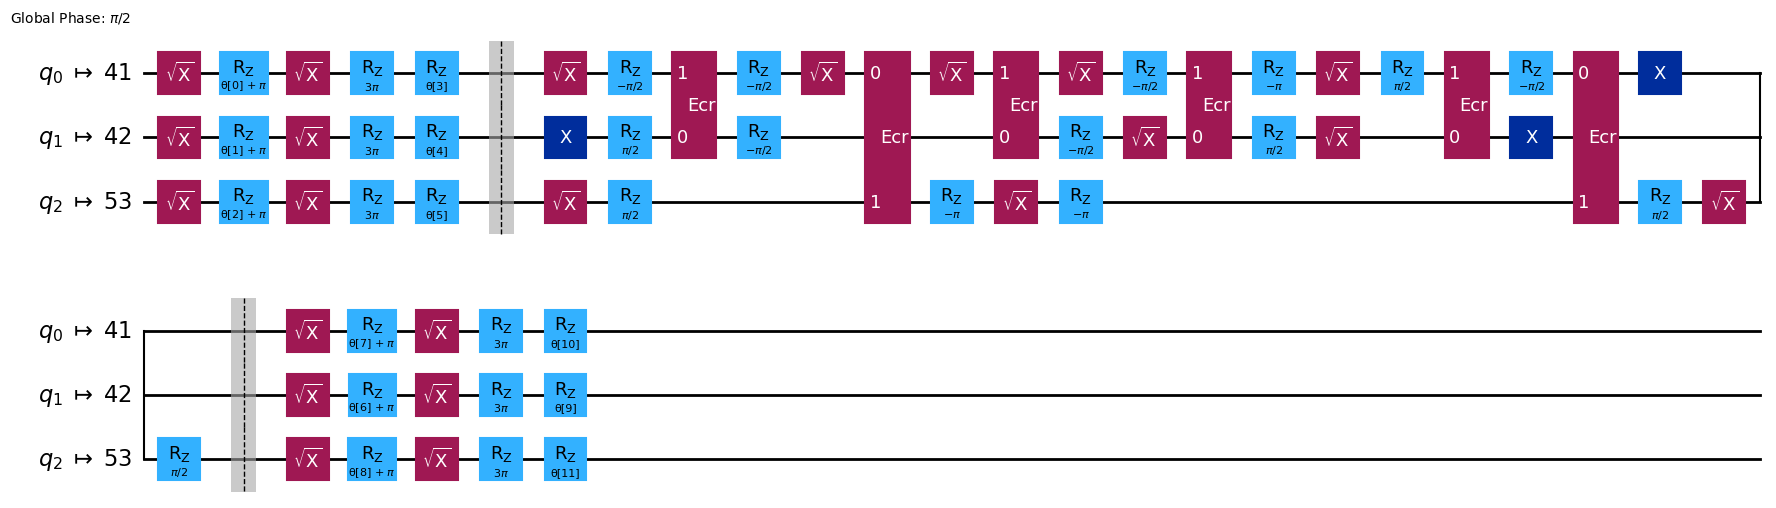

In [ ]:
# Qiskit Pattern Step 1: Map quantum circuits and operators (Define Ansatz and operators)
num_qubits = 3
rotation_blocks = ['ry', 'rz']
entanglement_blocks = 'cz'
entanglement = 'full'

# Define Ansatz
ansatz = TwoLocal(num_qubits, rotation_blocks, entanglement_blocks, entanglement, reps=1, insert_barriers=True)

# Define parameters
num_params = ansatz.num_parameters

# Qiskit Pattern Step 2: Optimize the circuit for quantum execution
optimization_level = 2
pm = generate_preset_pass_manager(backend=real_backend, optimization_level=optimization_level)
isa_circuit = pm.run(ansatz)

# Define Hamiltonian for VQE
pauli_op = SparsePauliOp(['ZII', 'IZI', 'IIZ'])
hamiltonian_isa = pauli_op.apply_layout(layout=isa_circuit.layout)
isa_circuit.draw('mpl', idle_wires=False)

In [ ]:
# Setup Qiskit Serverless Client and Qiskit Runtime client
client = IBMServerlessClient("insert token") # Add in your IBM Quantum Token to QiskitServerless Client

# For the challenge, we will be using QiskitRuntime Local testing mode. Change to True only if you wish to use real backend.
USE_RUNTIME_SERVICE = False

if USE_RUNTIME_SERVICE:
    service = QiskitRuntimeService(
        channel='ibm_quantum',
        verify=False
    )
else:
    service = None

# Define the Qiskit Function
if USE_RUNTIME_SERVICE:
    function = QiskitFunction(title="vqe", entrypoint="vqe.py", working_dir="./vqe")
else:
    function = QiskitFunction(title="vqe", entrypoint="vqe.py", working_dir="./vqe", dependencies=["qiskit_aer"])


In [ ]:
# Upload the Qiskit Function using IBMServerlessClient
client.upload(function)

QiskitServerlessException: Entrypoint file [vqe.py] does not exist in [./vqe] working directory.

In [ ]:
%pwd

'/content'

In [ ]:
# Define input_arguments
input_arguments = {
    "ansatz": isa_circuit,
    "operator": hamiltonian_isa,
    "method": "COBYLA",
    "service": service,
}

# Qiskit Pattern Step 3: Run the payload on backend
job = client.run("vqe", arguments= input_arguments)

In [ ]:
# Submit your answer using following code

grade_lab3_qs_ex1(function, input_arguments, job)
# Expected result type: QiskitFunction, dict, Job

job

Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.


<Job | a9898586-2cc6-447a-b873-862679098e50>

In [ ]:
# Check job completion status
job.status()

'QUEUED'

In [ ]:
# Monitor log
logs = job.logs()

for log in logs.splitlines():
    print(log)


No logs yet.


In [ ]:
# Return result from QiskitFunction job
job.result()

{'optimal_point': [6.075288227919253,
  3.131973196804596,
  3.129984076990872,
  6.186844550320411,
  4.0670232545172595,
  4.815757092046913,
  3.3079607785760357,
  -0.008630369373353356,
  0.0008348289459859082,
  4.871090706692177,
  6.423383702844317,
  3.9812333276723058],
 'optimal_value': -2.9990234375,
 'optimizer_time': 3.2408916261047125,
 'iters': 141,
 'cost_history': [0.30078125,
  -0.38916015625,
  0.08642578125,
  0.27783203125,
  -0.4072265625,
  -0.55859375,
  -0.5517578125,
  -0.7041015625,
  -0.4365234375,
  -0.79736328125,
  -0.78271484375,
  -0.77783203125,
  -0.79443359375,
  -1.0810546875,
  -1.3662109375,
  -1.4404296875,
  -1.3408203125,
  -1.54150390625,
  -1.42333984375,
  -1.37158203125,
  -1.5029296875,
  -1.23974609375,
  -2.0537109375,
  -2.02001953125,
  -2.056640625,
  -2.07861328125,
  -1.80224609375,
  -2.29638671875,
  -2.5654296875,
  -2.03515625,
  -2.79931640625,
  -2.8466796875,
  -2.6064453125,
  -2.7939453125,
  -2.37939453125,
  -2.756347656

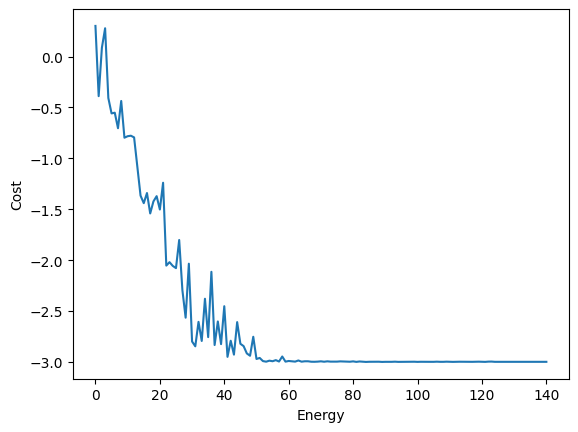

In [ ]:
# Qiskit Pattern Step 4: Postprocess and analyze the Estimator V2 results
result = job.result()

fig, ax = plt.subplots()
plt.plot(range(result["iters"]), result["cost_history"])
plt.xlabel("Energy")
plt.ylabel("Cost")
plt.draw()

In [ ]:
# Setup 3 circuits with Efficient SU2
num_qubits = [41, 51, 61]
circuits = [EfficientSU2(nq, su2_gates=["rz","ry"], entanglement="circular", reps=1).decompose() for nq in num_qubits]

In [ ]:
# Setup Qiskit Runtime Service backend

QiskitRuntimeService.save_account(
    channel="ibm_quantum",
    token="insert token",
    set_as_default=True,
    # Use 'overwrite=True' if you're updating your token.
    overwrite=True,
)

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.backend("ibm_brisbane")

In [ ]:
# Define Configs
optimization_levels = [1, 2, 3]
pass_managers = [{'pass_manager': generate_preset_pass_manager(optimization_level=level, backend=backend), 'optimization_level': level} for level in optimization_levels]

transpiler_services = [
        {'service': TranspilerService(backend_name="ibm_brisbane", ai='false', optimization_level=3), 'ai': False, 'optimization_level': 3},
        {'service': TranspilerService(backend_name="ibm_brisbane", ai='true', optimization_level=3), 'ai': True, 'optimization_level': 3}
    ]

configs = pass_managers + transpiler_services

In [ ]:
# Local transpilation setup
def transpile_parallel_local(circuit: QuantumCircuit, config):
    """Transpilation for an abstract circuit into an ISA circuit for a given config."""
    transpiled_circuit = config.run(circuit)
    return transpiled_circuit

In [ ]:
# Run local transpilation
warnings.filterwarnings("ignore")

start = timer()

# Run transpilations locally for baseline
results = []
for circuit in circuits:
    for config in configs:
        if 'pass_manager' in config:
            results.append(transpile_parallel_local(circuit, config['pass_manager']))
        # else:
        #     results.append(transpile_parallel_local(circuit, config['service']))

end = timer()

# Record local execution time
execution_time_local = end - start
print("Execution time locally: ", execution_time_local)

KeyboardInterrupt: 

In [ ]:
serverless = IBMServerlessClient("insert token")

In [ ]:
transpile_parallel_function = QiskitFunction(
    title="transpile_parallel",
    entrypoint="transpile_parallel.py",
    working_dir="./transpile_parallel",
    dependencies=["qiskit-transpiler-service"]
)



In [ ]:
serverless.upload(transpile_parallel_function )

'transpile_parallel'

In [ ]:
# Get list of functions
serverless.list()

[QiskitFunction(transpile_parallel), QiskitFunction(vqe)]

In [ ]:
# Fetch the specific function titled "transpile_parallel"
transpile_parallel_serverless = serverless.get('transpile_parallel')
print(transpile_parallel_serverless)

QiskitFunction(transpile_parallel)


In [ ]:
# Run the "transpile_parallel" function in the serverless environment
job = transpile_parallel_serverless.run(
    circuits=circuits,
    backend_name="ibm_brisbane",
    )

In [ ]:
# Extract necessary information from the backend object
# backend_name = job.result()['backend_name']

# Pass only the necessary information to the grading function
grade_lab3_qs_ex2(optimization_levels, transpiler_services, transpile_parallel_function, transpile_parallel_serverless, job)
# grade_lab3_qs_ex2()


Submitting your answer. Please wait...
Congratulations 🎉! Your answer is correct and has been submitted.
